In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import tqdm
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import keras
from keras.models import Sequential, model_from_yaml, Model
from keras.layers import Dense, Dropout, BatchNormalization, Activation,  Flatten, \
        MaxPooling1D, MaxPooling2D, GRU, LSTM, GlobalAveragePooling2D, Reshape
from keras.optimizers import Adam
from keras import backend as K
from tensorflow.python.client import device_lib
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
warnings.filterwarnings('ignore')

print(device_lib.list_local_devices())
config = tf.ConfigProto(device_count={"CPU": 1, "GPU" : 1})
session = tf.Session(config=config)
K.set_session(session)


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1258338658903796327
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4945621811
locality {
  bus_id: 1
  links {
  }
}
incarnation: 170241665115391612
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [2]:
train = pd.read_csv(r"c:\users\ajaln\train\train.csv", usecols=["acoustic_data", "time_to_failure"], 
                    dtype={"acoustic_data":np.int16, "time_to_failure":np.float64})


In [3]:
print(train.shape)
train.head()

(629145480, 2)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
acoustic_data,629145480.0,4.519468,10.735707,-5515.000000,2.000000,5.000000,7.000000,5444.0000
time_to_failure,629145480.0,5.678292,3.672697,0.000096,2.625997,5.349798,8.173396,16.1074


In [5]:
train[train["time_to_failure"]<=0.000098].describe().T

,count,mean,std,min,25%,50%,75%,max
acoustic_data,4538.0,4.834288,2.855084e+00,-5.000000,3.000000,5.000000,7.000000,16.000000
time_to_failure,4538.0,0.000097,7.205839e-07,0.000096,0.000096,0.000097,0.000097,0.000098


In [6]:
train.shape[0]/150000

4194.3032

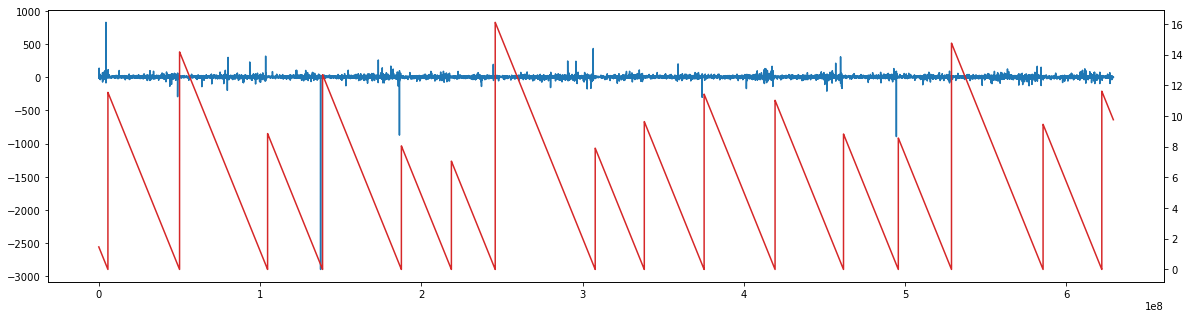

In [7]:
fig, ax1 = plt.subplots(figsize=[20,5])
ax2 = ax1.twinx()
ax1.plot(train.iloc[::4096,0], color= 'tab:blue')
ax2.plot(train.iloc[::4096,1], color= 'tab:red')
plt.show()

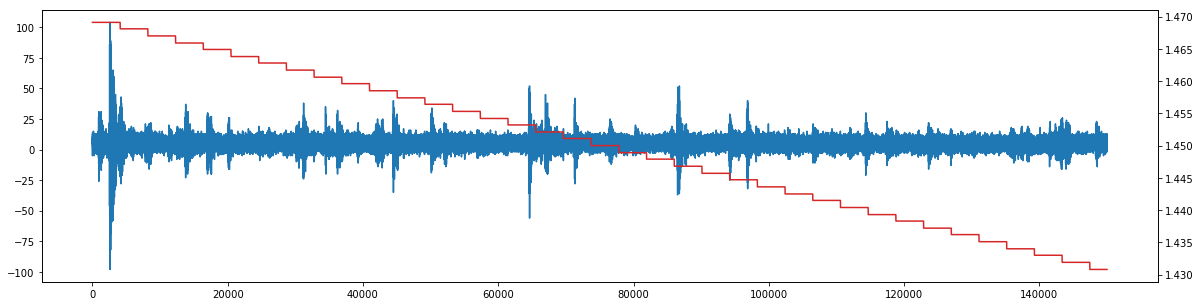

In [8]:
fig, ax1 = plt.subplots(figsize=[20,5])
ax2 = ax1.twinx()
ax1.plot(train.iloc[:150000,0], color= 'tab:blue')
ax2.plot(train.iloc[:150000,1], color= 'tab:red')
plt.show()

In [9]:
train["div"] = np.diff(train["time_to_failure"], axis=0, append=1)

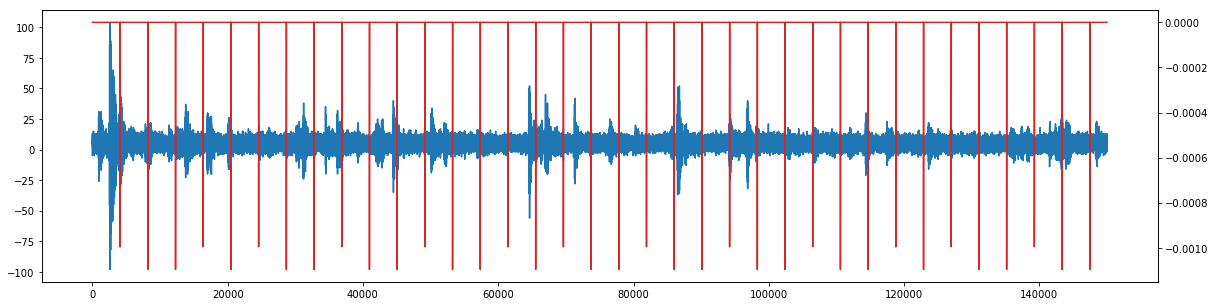

In [10]:
fig, ax1 = plt.subplots(figsize=[20,5])
ax2 = ax1.twinx()
ax1.plot(train.iloc[:150000,0], color= 'tab:blue')
ax2.plot(train.iloc[:150000,2], color= 'tab:red')
plt.show()

In [11]:
maximums = train[train["div"]<-0.0005]

In [12]:

gc.collect()

19463

In [13]:
np.median(np.diff(maximums.index, axis=0, append=1))

4096.0

In [14]:
train.shape[0]/4096/16

9599.998168945312

In [15]:
peaks = train[train["div"]>0]

In [16]:
peaks

,acoustic_data,time_to_failure,div
5656573,4,0.000795,11.540005
50085877,8,0.000695,14.179905
104677355,6,0.000795,8.855905
138772452,3,0.001095,12.692905
187641819,7,0.000595,8.054905
218652629,5,0.001095,7.057905
245829584,1,0.000495,16.106905
307838916,7,0.000695,7.904905
338276286,4,0.000195,9.636905
375377847,0,0.000495,11.425905


In [17]:
samples = 9600-2
img = np.empty([0,5,3000,1])
dep = np.empty([0])
with tqdm.tqdm(total=samples) as bar:
    for a in range(0, samples):
        offset = 4096*a*16
        single_sample = train.iloc[offset:offset+150000]
        w1 = pywt.cwt(single_sample["acoustic_data"], [1, 5, 10, 15, 20], "mexh")[0][:,::50]
        img = np.append(img, w1.reshape(1,5,3000,1), axis=0)
        dep = np.append(dep, single_sample["time_to_failure"].min())
        bar.update(1)
np.save("indep.npy", img)
np.save("dep.npy", dep)

  7%|█████▍                                                                         | 660/9598 [00:43<09:54, 15.04it/s]


KeyboardInterrupt: 

In [ ]:
np.save("indep.npy", img)
np.save("dep.npy", dep)

In [ ]:
fig, ax = plt.subplots(40, 10, figsize=(16, 32))
for j in range (0, 40):
    for i in range (0, 10):
        ax[j, i].axis("off")
        ax[j, i].imshow(img[i+j*10,:,:,0], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
from keras.callbacks import *

class CyclicLR(Callback):
 
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        


In [ ]:
with tf.device('/device:GPU:0'):
    model =[]
    for i in range (0, 4):
        indep_train, indep_val, dep_train, dep_val = train_test_split(img, dep, test_size=0.30)
        gs1 = Sequential()
        gs1.add(Convolution2D(128, (3,3), input_shape=(5, 3000, 1), activation='selu'))
        gs1.add(BatchNormalization())
        gs1.add(MaxPooling2D(pool_size=(1,2)))
        gs1.add(Convolution2D(128, (3,3), activation='selu'))
        gs1.add(Convolution2D(128, (1,3), activation='selu'))
        gs1.add(GlobalAveragePooling2D())
        gs1.add(Dropout(0.3))
        gs1.add(BatchNormalization())
        gs1.add(Dense(1, activation='linear'))
        gs1.compile(Adam(), loss='mean_squared_error', metrics = ['mae'])
        
        clr_triangular = CyclicLR(base_lr=5e-6, max_lr=0.005, mode="triangular2", step_size=2000)
        
        gs1.fit(indep_train, dep_train, validation_data=(indep_val, dep_val), batch_size=32, epochs=50, 
                callbacks = 
                          [
                          ModelCheckpoint("lanl{0}.h5".format(i), monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min'),
                          clr_triangular],
                verbose=2)
        model.append(gs1)

In [ ]:
with open(r"lanl.yaml".format(i), "w") as yaml_file:
    yaml_file.write(gs1.to_yaml())

In [ ]:
fig, ax = plt.subplots(1, 1, sharex='col', figsize=(20, 10))
ax.set_title('Model error history')
ax.plot(gs1.history.history['mean_absolute_error'])
ax.plot(gs1.history.history['val_mean_absolute_error'])
ax.set_ylabel('Error')
ax.legend(['train', 'test'], loc='right')
ax.grid()
plt.show()

In [ ]:
indep_train, indep_val, dep_train, dep_val = train_test_split(img, dep, test_size=0.30)

val = pd.DataFrame()
for i in [0,1,2,3]:
    with open(r"lanl.yaml".format(i), "r") as yaml_file:
        K.clear_session()
        m = model_from_yaml(yaml_file.read())
        m.load_weights(r"lanl{0}.h5".format(i))
        a = m.predict(indep_val)
        val["model_{0}".format(i)] = pd.Series(a.reshape(len(a)))
        
print(mean_absolute_error(val.iloc[:,:].mean(axis=1), dep_val))

In [ ]:
"""
submission = pd.read_csv('sample_submission.csv', index_col = None)
test = np.empty([0,5,3000,1])
with tqdm.tqdm(total=submission.shape[0]) as bar:
    for seg_id in submission["seg_id"]:
        single_sample = pd.read_csv('c:/users/ajaln/test/'+seg_id + '.csv')
        w1 = pywt.cwt(single_sample["acoustic_data"], [1, 5, 10, 15, 20], "mexh")[0][:,::50]
        test = np.append(test, w1.reshape(1,5,3000,1), axis=0)
        bar.update(1)
np.save("res.npy", test)
""";

test = np.load("res.npy")

data = pd.DataFrame()
for i in range(0, 4):
    with open(r"lanl.yaml".format(i), "r") as yaml_file:
        K.clear_session()
        m = model_from_yaml(yaml_file.read())
        m.load_weights(r"lanl{0}.h5".format(i))
        a = m.predict(test)
        data["model_{0}".format(i)] = pd.Series(a.reshape(len(a)))
        
submission["time_to_failure"] = data.iloc[:,:].mean(axis=1)
submission.to_csv(r"c:/work/dataset/earthquake/cnn.csv", index=False)